In [141]:
""" 
    Multi layer perceptron (MLP) 

    by Marcos Rocha (marcosrh@cio.mx)

    This mlp is defined as a class with several functions to generate the necessary data 
    in each step of the initialization, training, prediction and plotting process.

 """


#Import the necessary libraries
import numpy as np
import time
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import math
import sys
from numba import vectorize
from numba import autojit



#Create the mlp class 
class mlp:
    
    def __init__(self, lr, epochs, activation):
        
        """ Here its defined the activation function to be used as str(), the learning rate (lr) and the                    number of epochs """

        self.activation = activation
        self.lr = lr
        self.epochs = epochs
    
    #Function to create the input layer with a number of neurons defined by user
    #the number of inputs is defined by the dataset inputs(as a matrix of 2 dimensions) as len(inputs[1])
    def input_layer(self, num_neurons, num_inputs):
        
        x = np.array([np.random.rand(num_inputs+1,1) for i in range(num_neurons)])

        self.fully_connected = num_neurons
        
        return x

    #Hidden layers function, the model is fully connected
    def hidden_layer(self, num_neurons):
       
        x = np.array([np.random.rand(self.fully_connected+1,1) for i in range(num_neurons)])
        
        self.fully_connected = num_neurons
    
        return x

    #Output layer function
    def output_layer(self,num_neurons):
        
        x = np.array([np.random.rand(self.fully_connected+1,1) for i in range(num_neurons)])

        return x
    
    def init_model(self, config_in_layer, config_hid_layers):
        """ initialize model with random values for the weights (including bias weight)

            config_in_layer = int(num_neurons), num_neurons is the number of neurons on the input layer and                 num_inputs is the number of inputs on each neuron

            config_hid_layers = array[], the length of the array is the number of hidden layers and the value               in each position of the array is the number of neurons for the related hidden layer

            config_out_layer = int(), the number of neurons for the output layer

            Example:
                init_model(2,[4,3],1) ----- This will create a network with a input layer with 2 neurons, two                                              hidden layers with 4 and 3 neurons respectively and an output                                                  layer with 1 neuron

         """
    
        #the network model will be treated as a list()
        model = []
        
        #Create the input layer and add it to the model list
        x = self.input_layer(config_in_layer, self.num_inputs)
        model.append(x)
        
        #Create len(config_hid_layers) hidden layers and append them to model
        for i in range(0,len(config_hid_layers)):
            x = self.hidden_layer(config_hid_layers[i])
            model.append(x)
            
        #Create the output layer and append it to model
        x = self.output_layer(self.num_outputs)   
        model.append(x)
        
        return model

   

    def logic_gate_dataset(self,logic_gate):
        
        """ 
        Function that returns two arrays, one for inputs and othe for outputs, for the desired type of                 logic gate.
        From an array of all posible combinatios of inputs depending on which gate wants to be solved by               the model, some values of the arrays will be deleted to generate the exact array for the desired               logic gate  
        """
        
        inputs = np.array([
            [0,0],
            [0,0],
            [0,1],
            [0,1],
            [1,0],
            [1,0],
            [1,1],
            [1,1]
            ])
        
        outputs = [[0],[1],[0],[1],[0],[1],[0],[1]]

        if logic_gate == 'and':
            index = [1,3,5,6]
            l=0
            for i in index:
                inputs=np.delete(inputs, i-l, 0)
                outputs=np.delete(outputs,i-l,0)
                l+=1
        elif logic_gate == 'or':
            index = [1,2,4,6]
            l=0
            for i in index:
                inputs=np.delete(inputs, i-l, 0)
                outputs=np.delete(outputs,i-l,0)
                l+=1
        elif logic_gate == 'nand':
            index = [0,2,4,7]
            l=0
            for i in index:
                inputs=np.delete(inputs, i-l, 0)
                outputs=np.delete(outputs,i-l,0)
                l+=1
        elif logic_gate == 'nor':
            index = [0,3,4,7]
            l=0
            for i in index:
                inputs=np.delete(inputs, i-l, 0)
                outputs=np.delete(outputs,i-l,0)
                l+=1
        elif logic_gate == 'xor':
            index = [1,2,4,7]
            l=0
            for i in index:
                inputs=np.delete(inputs, i-l, 0)
                outputs=np.delete(outputs,i-l,0)
                l+=1     
        inputs = np.append(inputs, inputs, axis = 1)
        
        outputs = np.append(outputs, outputs, axis = 1)
        #Here the number of inputs for each neuron in the input layer is defined
        #Example: If the inputs array has the shape (4,2) then the number of inputs is 2
        self.num_inputs = len(inputs[1])
        self.num_outputs = len(outputs[1])
        return inputs,outputs
    
    def act_funct(self,z):

        """ 
        This functions contains the activation function to be used in each layer of the network
        For this work it's only used the sigmoid, the other activation functions defined here are only for             testing.
        """
        
        if self.activation == 'sig':
            y = 1/(1+np.exp(-z))
        elif self.activation == 'tanh':
            y = (1.0 - np.exp(-2*z))/(1.0 + np.exp(-2*z))
        
        """ elif self.activation == 'soft':
            e = np.exp(z)
            y = e / np.sum(e) """
        """ elif self.activation == 'relu':
            y = max(0.0, z) """
        
        return y

    def output_error_mse(self, predictions, targets):
        
        #error_ = np.array([])
        
        #samples_num = len(predictions)
        
        accumulated_error = 0.0
        
        accumulated_error = sum(np.power(predictions - targets,2))
        
        mae_error = (1.0 / (2)) * np.mean(accumulated_error)
        
        #error_ = np.append(error_,mae_error)
        
        return mae_error
    
    def feed_forward(self, model, inputs):

        model_activations = []

        inputs = np.append(inputs, np.ones((len(inputs),1)),axis=1)

        inputs = inputs.T
        
        c = 0
        for layer in model:
            
            """ if c == len(model)-1:
                self.activation = 'soft' """
            
            z = np.dot(np.transpose(layer,(0,2,1)),inputs)
            
            a = self.act_funct(z)
            
            model_activations.append(np.transpose(a,(0,2,1)))
            
            a = np.squeeze(a,axis=1)
            
            a = np.append(a,np.ones((a.shape[1],1)).T,axis=0)
            
            inputs = a
            c+=1
            

            
        return model, model_activations

    
    def act_funct_prime(self,layer_activations):
        
        if self.num_outputs > 1:
            acts = layer_activations
        else:
            acts = np.squeeze(layer_activations,axis=2).T
        
        
        
        if self.activation == 'sig':
            
        
            sigmoid_prime = acts * (np.ones((acts.shape[0],acts.shape[1])) - acts) 
        
        elif self.activation == 'tanh':
            #print(layer_activations.shape)
            #acts = np.squeeze(layer_activations,axis=2).T
            
            sigmoid_prime = (np.ones((acts.shape[0],acts.shape[1])) + acts)*(np.ones((acts.shape[0],acts.shape[1])) - acts)
        
            """ elif self.activation == 'soft':
            acts = np.squeeze(layer_activations,axis=2).T """
            #s = acts.reshape(-1,1)
            #S_vector = layer_activations.reshape(layer_activations.shape[0],1)
            """ S_matrix = np.tile(layer_activations,layer_activations.shape[0])
            sigmoid_prime = np.diag(layer_activations) - (S_matrix * np.transpose(S_matrix)) """
            """ sigmoid_prime = acts * (np.ones((acts.shape[0],acts.shape[1])) - acts) """

        """ elif self.activation == 'relu':
            sigmoid_prime = (acts > 0) * 1 """

        return sigmoid_prime
    
    def delta_output(self, layer_activations, outputs):
        if self.num_outputs > 1:
            layer_activations = np.squeeze(layer_activations,axis=2).T
            
            error_output = outputs - layer_activations

            delta_output = error_output * self.act_funct_prime(layer_activations)
            #print(delta_output.shape)

            #delta_output = np.squeeze(delta_output, axis=0)
            
        else:
            error_output = outputs - layer_activations

            delta_output = error_output * self.act_funct_prime(layer_activations)

            delta_output = np.squeeze(delta_output, axis=0)

        
        return delta_output
    
    def update_output_weights(self, model, model_activations, delta_output):

        prev_acts = np.squeeze(model_activations[len(model_activations)-2],axis=2)
        
        #print(delta_output.T.shape, prev_acts.T.shape)
        dC = np.dot(delta_output.T, prev_acts.T).T
        #print(dC.shape)
        dC = np.append(dC, [[np.mean(delta_output[:,i]) for i in range(len(delta_output[1]))] ], axis=0)
        #print(dC.shape)
        if self.num_outputs > 1:
            dC = dC[...,np.newaxis]
            dC = np.transpose(dC, (1,0,2))
        else:
        
            model[len(model)-1] += self.lr * dC
        
        return model
    
    def delta_hidden_layer(self, model, upper_layer_delta, layer_activations):
        
        if self.num_outputs > 1:
            layer_activations = np.squeeze(layer_activations)

            layer_prime = self.act_funct_prime(layer_activations)
        
            w_up = np.squeeze(model, axis=2).T
            w_up = np.delete(w_up,len(w_up)-1,0)

            upper_prod = np.dot(upper_layer_delta,w_up.T)
        
            delta_hidden = upper_prod*layer_prime.T

        else:
            layer_prime = self.act_funct_prime(layer_activations)
    
            w_up = np.squeeze(model, axis=2).T
            w_up = np.delete(w_up,len(w_up)-1,0)

            upper_prod = np.dot(upper_layer_delta,w_up.T)
        
            delta_hidden = upper_prod*layer_prime
            
        return delta_hidden

    
    def update_hidden_weights(self, model, delta_output, model_activations,inputs):

        upper_layer_delta = delta_output

        for i in reversed(range(len(model)-1)):
            
            means = np.array([])
            
            if i == 0:
                delta_layer = self.delta_hidden_layer(model[i+1],upper_layer_delta,model_activations[i])
                upper_layer_delta = delta_layer
                
                for j in range(delta_layer.shape[1]):
                    means = np.append(means, [np.mean(delta_layer[:,j])])

                means = means[..., np.newaxis]
                
                
                dC = np.dot(delta_layer.T,inputs)
          
                
                dC = np.append(dC, means, axis=1)
                dC = dC[...,np.newaxis]
                
                model[i] += self.lr * dC

            else:
                delta_layer = self.delta_hidden_layer(model[i+1],upper_layer_delta,model_activations[i])
                upper_layer_delta = delta_layer
                
                for j in range(delta_layer.shape[1]):
                    means = np.append(means, [np.mean(delta_layer[:,j])])

                means = means[..., np.newaxis]
               
                acts = np.squeeze(model_activations[i-1], axis=2)
                dC = np.dot(delta_layer.T,acts.T)
                
                dC = np.append(dC, means, axis=1)
                dC = dC[...,np.newaxis]
                
                model[i] += self.lr * dC 
            
        
        return model
    
    def backpropagation(self,model, model_activations, outputs,inputs):

        delta_output = self.delta_output(model_activations[len(model)-1],outputs)

        model = self.update_output_weights(model, model_activations, delta_output)

        model = self.update_hidden_weights(model, delta_output, model_activations, inputs)

        return model
    
    
    def train_model(self, model, inputs, outputs):

        error_hist = []
        t_0 = time.time()

        for e in range(self.epochs):
            print("Epoch: ", e)
            
            model, model_activations = self.feed_forward(model, inputs)
            
            if self.num_outputs > 1: c = np.squeeze(model_activations[len(model)-1])
            else: c = model_activations[len(model)-1]
            
            for k in range(len(outputs)):
                
                achieved = '     ' + str(outputs[k]) + '-----------' + str(c[:,k])
                print(achieved)
            print('model error: ', self.output_error_mse(model_activations[len(model)-1],outputs))
            error_hist.append(self.output_error_mse(model_activations[len(model)-1],outputs))

            model = self.backpropagation(model,model_activations,outputs,inputs)
        
        t_1 = time.time()
        t_f = t_1 - t_0
        
        print("Required time = ",t_f)
        
        plt.plot(range(1, len(error_hist) + 1), error_hist, marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Cost values')
        plt.tight_layout()
        plt.grid()
        plt.show()

        return model
    
    def predict_single(self,model,inputs):
        
        outputs, acts = self.feed_forward(model, inputs)

        return outputs,acts
    
    def predict(self, X,model):
        
        Y = np.array([])
        
        for x in X:
            x = x[...,np.newaxis]
            
            m, a = self.predict_single(model,x.T)
            
            c = np.squeeze(a[len(model)-1], axis=2)
            
            y = np.array(c)
            
            Y = np.append(Y, y)
        return Y

    def plot_decision_regions(self,X, y, model, test_idx=None, resolution=0.02):

        # setup marker generator and color map
        markers = ('s', 'x', 'o', '^', 'v')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        # plot the decision surface
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
        Z = self.predict(np.array([xx1.ravel(), xx2.ravel()]).T, model)
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        # plot class samples
        y = np.squeeze(y)
        #print(y.shape)
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                        alpha=0.8, c=cmap(idx),
                        marker=markers[idx], label=cl)

        # highlight test samples
        if test_idx:
            # plot all samples
            X_test, y_test = X[test_idx, :], y[test_idx]

            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        alpha=1.0,
                        linewidths=1,
                        marker='o',
                        s=55, label='test set')
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()


Epoch:  0
     [0 0]-----------[0.69702458 0.78315518]
     [1 1]-----------[0.70307879 0.78646772]
     [1 1]-----------[0.7028695  0.78639175]
     [0 0]-----------[0.70330791 0.78664707]
model error:  0.3100380249092325
Epoch:  1
     [0 0]-----------[0.69681624 0.78300226]
     [1 1]-----------[0.70296789 0.78635944]
     [1 1]-----------[0.70275425 0.78628248]
     [0 0]-----------[0.70320108 0.78654203]
model error:  0.3099607652700188
Epoch:  2
     [0 0]-----------[0.69660157 0.7828446 ]
     [1 1]-----------[0.70285325 0.78624726]
     [1 1]-----------[0.70263513 0.7861693 ]
     [0 0]-----------[0.70309064 0.78643318]
model error:  0.30988110777469235
Epoch:  3
     [0 0]-----------[0.6963803  0.78268201]
     [1 1]-----------[0.70273472 0.78613098]
     [1 1]-----------[0.70251195 0.786052  ]
     [0 0]-----------[0.70297641 0.78632032]
model error:  0.30979895165642657
Epoch:  4
     [0 0]-----------[0.69615216 0.78251427]
     [1 1]-----------[0.7026121  0.78601039]
     [

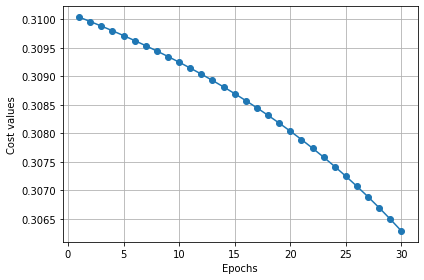

ValueError: shapes (2,1,5) and (3,1) not aligned: 5 (dim 2) != 3 (dim 0)

In [142]:
ml = mlp(0.3,30,'tanh')

inputs, outputs  = ml.logic_gate_dataset('xor')

model = ml.init_model(2,[3,2])

model = ml.train_model(model, inputs, outputs)
ml.plot_decision_regions(inputs, outputs, model)
